# Project with convolutional neural networks (CNN)

In this project, we will use an American Sign Language (ASL) database. It contains 87000 images of 200x200 pixels. There are 29 classes: letters A-Z, SPACE, DELETE and NOTHING. These last 3 classes are very helpful in real time applications, and classification. The test data set contains a mere 29 images, to encourage the use of real world test images. However, in this project, we will test the models with a partition of the train dataset by the use of one scikitlearn function.

In [4]:
#!pip install pillow
#!pip install opencv-python
#!wget https://www.dropbox.com/s/x46u9ibdw5ph3t7/mini_asl_alphabet.zip
#!unzip mini_asl_alphabet.zip

In [5]:
#!pip install opencv-python
#!apt update && apt install -y libsm6 libxext6
#!sudo apt-get install libxrender1

Samples images for letter A


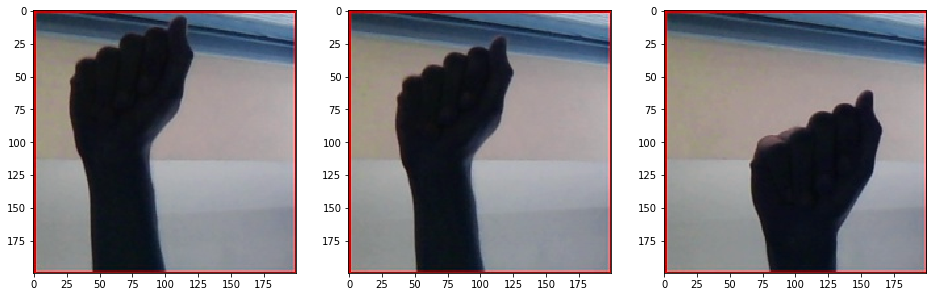

In [1]:
# import tensorflow.contrib.eager as tfe
# Enable eager execution
# tfe.enable_eager_execution()
# Imports for Deep Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

# ensure consistency across runs
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random

def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = './mini_asl_alphabet/asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

plot_three_samples('A')

In [8]:
data_dir = "./mini_asl_alphabet/asl_alphabet_train"
target_size = (64, 64)
target_dims = (64, 64, 3) # add channel for RGB
num_classes = 29
val_frac = 0.1
batch_size = 64
num_epochs = 30
workers = 48
data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

test_datagen = ImageDataGenerator(samplewise_center=True, 
                                  samplewise_std_normalization=True)

train_generator = data_augmentor.flow_from_directory(data_dir, 
                                                     target_size=target_size, 
                                                     batch_size=batch_size, 
                                                     shuffle=True, 
                                                     subset = "training")

val_generator = data_augmentor.flow_from_directory(data_dir, 
                                                   target_size=target_size, 
                                                   batch_size=batch_size,
                                                   shuffle = False,
                                                   subset = "validation")

test_generator = test_datagen.flow_from_directory(directory=r"./mini_asl_alphabet/asl_alphabet_test",
                                                  target_size=(64, 64),
                                                  color_mode="rgb",
                                                  batch_size = 1,
                                                  class_mode = None,
                                                  shuffle = False,
                                                  seed = 42)

Found 2610 images belonging to 29 classes.
Found 290 images belonging to 29 classes.
Found 0 images belonging to 0 classes.


## Comparation of different CNN Models

In [9]:
def get_conv_model_A(num_classes, img_shape = (64,64,3), compile = True):
    # Destroys the current TF graph and creates a new one
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    #create sequential model
    model = Sequential()
    #add model layers
    model.add(Conv2D(8, kernel_size = 10, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

def get_conv_model_B(num_classes, img_shape = (64,64,3), compile = True):
    # Destroys the current TF graph and creates a new one
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    #create sequential model
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size = 10, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

def get_conv_model_C(num_classes, img_shape = (64,64,3), compile = True):
    # Destroys the current TF graph and creates a new one
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    #create sequential model
    model = Sequential()
    #add model layers
    model.add(Conv2D(64, kernel_size = 5, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Conv2D(64, kernel_size = 5, activation = 'relu', input_shape=img_shape))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

def get_conv_model_D(num_classes, img_shape=(64,64,3), compile = True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
    model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    if compile == True:
        model.compile(optimizer='adam', 
                         loss='categorical_crossentropy', 
                         metrics=["accuracy"])
    return model

In [10]:
model = get_conv_model_A(num_classes)
model.summary()
historyModelA = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)
#model.save('modelA.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 8)         2408      
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 24200)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1548864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1885      
Total params: 1,553,157
Trainable params: 1,553,157
Non-trainable params: 0
_________________________________________________________________


In [12]:
model = get_conv_model_B(num_classes)
model.summary()
historyModelB = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)
#model.save('modelB.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 64)        19264     
_________________________________________________________________
dropout (Dropout)            (None, 55, 55, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 193600)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12390464  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1885      
Total params: 12,411,613
Trainable params: 12,411,613
Non-trainable params: 0
________________________________________________________________

In [13]:
model = get_conv_model_C(num_classes)
model.summary()
historyModelC = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)
#model.save('modelC.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 64)        4864      
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        102464    
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12845120  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [14]:
model = get_conv_model_D(num_classes)
model.summary()
historyModelD = model.fit_generator(train_generator, epochs=num_epochs, validation_data = val_generator, workers=workers)
#model.save('modelD.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 61, 61, 64)        3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        65600     
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 256)         524544    
__________

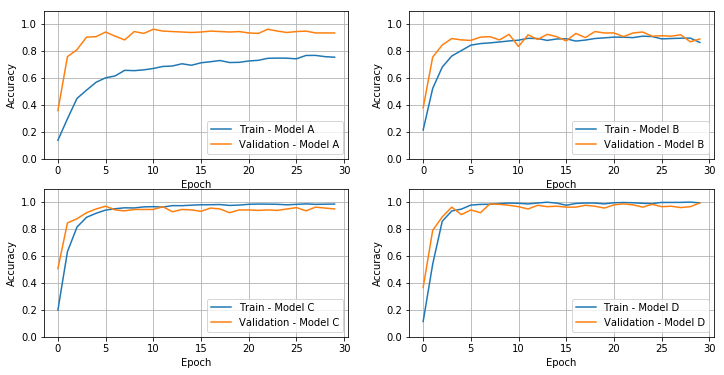

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

def plotResults(history, label = ['A', 'B', 'C', 'D']):
    for i in range(len(history)):
        plt.subplot(len(history) // 2, len(history) // 2 + len(history) % 2, i + 1)
        plt.ylim(0,1.1)
        plt.grid()
        plt.plot(history[i].history['acc'], label='Train - Model ' + label[i])
        plt.plot(history[i].history['val_acc'], label='Validation - Model ' + label[i])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.show()

plotResults([historyModelA, historyModelB, historyModelC, historyModelD])

In [4]:
from tensorflow.keras.models import load_model
model = load_model('./20191DL-G02/U3.Proyecto/modelD.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


#### Creación y manejo de flow_from_dataframe: [Tutorial on Keras flow_from_dataframe](https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c)

In [112]:
test_generator = test_datagen.flow_from_directory(directory=r"./mini_asl_alphabet/asl_alphabet_test",
                                                  target_size=(64, 64),
                                                  color_mode="rgb",
                                                  batch_size = 1,
                                                  class_mode = None,
                                                  shuffle = False,
                                                  seed = 42)

import pandas as pd
testdf=pd.read_csv("./testDataframe.csv",dtype=str)

test_generator = test_datagen.flow_from_dataframe(dataframe = testdf,
                                                directory=r"./mini_asl_alphabet/asl_alphabet_test/test",
                                                x_col="id",
                                                y_col="label",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(64,64))

test_generator.reset()
pred = model.predict_generator(test_generator,verbose=1)

Found 29 images belonging to 1 classes.
Found 29 images.
1/1 [==============================] - 0s 329ms/step


In [88]:
import numpy as np
pred = np.argmax(pred, axis=1)

In [117]:
y_test = np.array(testdf['label'])
y_test

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28'], dtype=object)

In [27]:
import numpy as np

predicted_class_indices=np.argmax(pred, axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

28


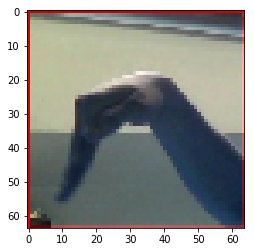

In [55]:
from PIL import Image

im = cv2.imread('./mini_asl_alphabet/asl_alphabet_test/test/del1.jpg')[:,:,:3]
im = Image.fromarray(im, 'RGB')
im = im.resize((64,64))
img_array = np.array(im)
plt.imshow(im, cmap=plt.cm.Greys_r)
img_array = np.array(im)
img_array = np.expand_dims(img_array, axis=0)
prediction = (model.predict(img_array)[0])
prediction = np.argmax(prediction)
print(prediction)

In [98]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

5/5 [==============================] - 3s 587ms/step
Accuracy = 98.9655172413793%
Normalized confusion matrix


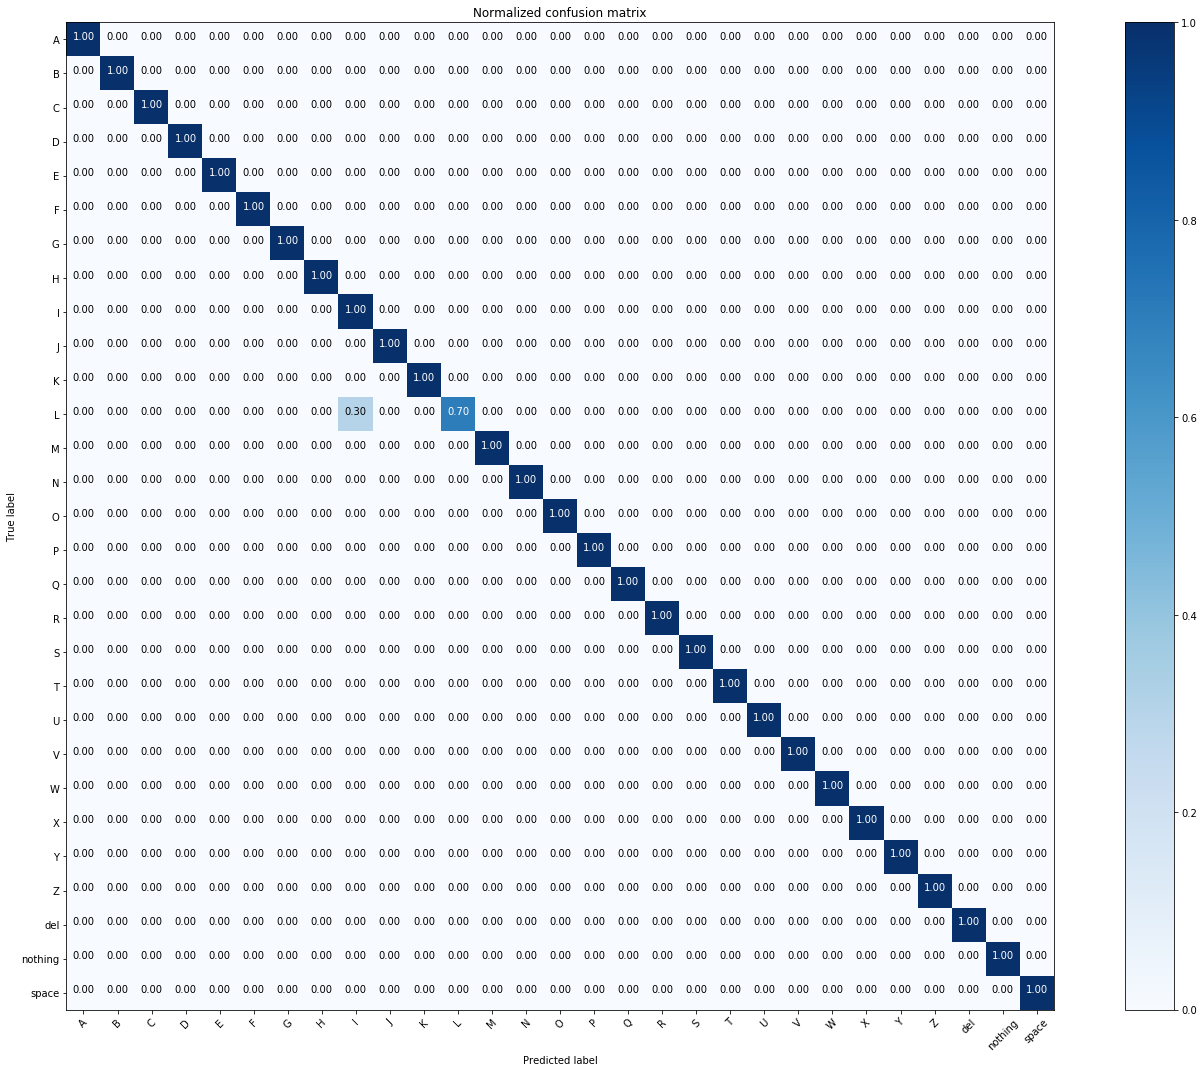

In [102]:
val_generator.reset()
preds = model.predict_generator(val_generator,verbose=1).argmax(axis = 1)

Accuracy = np.mean(preds == val_generator.classes)
print("Accuracy = " + str(Accuracy*100) + "%")

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_generator.classes, preds)
np.set_printoptions(precision=1)

# Plot normalized confusion matrix
plt.figure(figsize=(20,15))
plot_confusion_matrix(cnf_matrix, classes=val_generator.class_indices, 
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()